# Tracking ice floes in a series of binary images

In this example, we show how to use individual functions in the IceFloeTracker package to extract features from a sequence of binary images, prepare the property tables for each image to include the information needed for the tracker, and then run the tracker.

To start out, we need to activate the project and import the libraries we'll be using. The first time you run this notebook, you may need to use `Pkg.add()` to install libraries and then use `Pkg.resolve()` and `Pkg.instantiate()` to ready the libraries for use.

In [51]:
using Pkg;
HOME = "../.."
Pkg.activate(HOME)
Pkg.add("Plots") # Needed for plotting the examples in the notebook
using IceFloeTracker

# Functions used to load, view, and extract floe shapes
using IceFloeTracker: load, imshow, label_components, regionprops_table

# Functions for prepping the region props tables, and tracking floes
using IceFloeTracker: addfloemasks!, adduuid!, add_passtimes!, addψs!, long_tracker
using DataFrames, Dates, Plots, CSV

  Activating project at `~/Documents/research/packages/IceFloeTracker.jl`


# Loading images 

A sequence of test images with manually drawn and shifted "ice floes" is provided. In practice, the segmented images could be the output of the preprocessing functions from IceFloeTracker, manual ice floe maps, or the results of other image segmentation workflows. In this case the images are saved as PNG to save space, but other filetypes (e.g. TIFF) are perfectly fine.

,,,,,

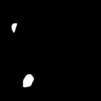
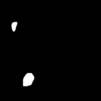
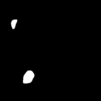
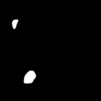
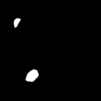
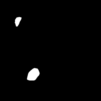

In [56]:
image_loc = "test/test_inputs/tracker_rotation/"
image_names = [joinpath(HOME, image_loc, "test_floes_0"*string(idx)*".png") for idx in range(1, 6)];
images = load.(image_names)
imshow.(images * 255)

# Measuring object properties

The example images are binary, so we need to label the connected components before extracting the region properties.

In [25]:
labeled_images = label_components.(images);
props = regionprops_table.(labeled_images);

Let's take a look at the property tables:

In [26]:
props[1]

Row,area,min_row,min_col,max_row,max_col,row_centroid,col_centroid,convex_area,major_axis_length,minor_axis_length,orientation,perimeter
,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,552.0,92,45,128,66,107,55,585.0,38.5088,19.4896,-0.212525,99.3553
2,1706.0,296,91,347,134,322,111,1754.0,57.2995,38.2431,-0.505226,159.882


As you can see, the object properties for the 2 floes in the image each get assigned a row. `regionprops_table` is a wrapper for the function of the same name from the Python `scikit-image` library. It extracts useful measurements of the shapes, including the position and bounding box. For the tracker though we'll need a few more things.

First, with real data we'd expect a timestamp to be associated with each of the images. We can use the Dates package to make a vector. Then, we use `addpasstimes!` to modify the props tables in place.

In [27]:
passtimes = collect(Date(2019,3,1):Day(1):Date(2019,3,6))
add_passtimes!(props, passtimes)

To keep track of objects across multiple images we add a unique ID to each row.

In [28]:
adduuid!(props);

Julia DataFrames can have many different types of entries. In particular, the entries don't have to be 1D. We'll add a cropped image of the floes via `addfloemasks!` and then characterize the boundary using a ψ-s curve. This curve describes the tangent angle of the floe (ψ) as a function of arc length along the boundary (s).

In [29]:
addfloemasks!(props, [im .> 0 for im in images]) # Images need to be bitmatrices for the floemasks call.
addψs!(props)

Each floe mask is cropped to the bounding box. We can view the masks for the first image via `imshow`:

,

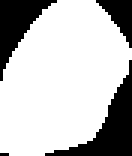
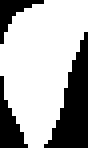

In [57]:
imshow.(props[1].mask)

Using the `Plots` library we can see how the ψ-s curves differ between the two floes. The black lines show the ψ-s curve for the smaller floe across all 6 images, while the red lines show the same for the larger floe.

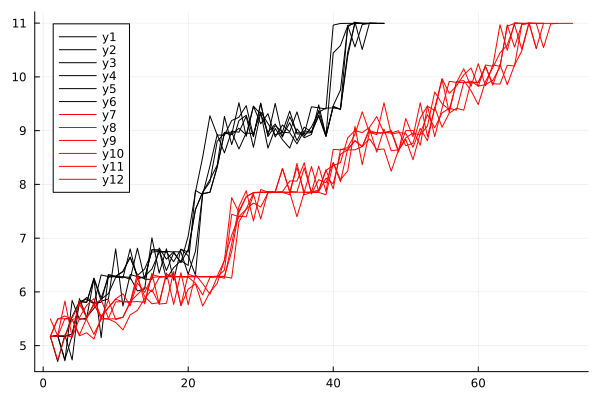

In [31]:
plt = plot([p[1,:psi] for p in props], lc=:black)
plot!([p[2,:psi] for p in props], lc=:red)

# Tracking

With the table sufficiently populated, we can now run the tracker. We can see the arguments needed by using the `?` functionality.


In [32]:
?long_tracker

search: contractuser logrange



```
long_tracker(props, condition_thresholds, mc_thresholds)
```

Track ice floes over multiple days.

Trajectories are built in two steps:

0. Get pairs of floes in day 1 and day 2. Any unmatched floes, in both day 1 and day 2, become the "heads" of their respective trajectories.
1. For each subsequent day, find pairs of floes for the current trajectory heads. Again, any unmatched floe in the new prop table starts a new trajectory.

# Arguments

  * `props::Vector{DataFrame}`: A vector of DataFrames, each containing ice floe properties for a single day. Each DataFrame must have the following columns:

      * "area"
      * "min_row"
      * "min_col"
      * "max_row"
      * "max_col"
      * "row_centroid"
      * "col_centroid"
      * "convex_area"
      * "major*axis*length"
      * "minor*axis*length"
      * "orientation"
      * "perimeter"
      * "mask": 2D array of booleans
      * "passtime": A timestamp for the floe
      * "psi": the psi-s curve for the floe
      * "uuid": a universally unique identifier for each segmented floe
  * `condition_thresholds`: namedtuple of thresholds for deciding whether to match floe `i` from day `k` to floe j from day `k+1`. See `IceFloeTracker.condition_thresholds` for sample values.
  * `mc_thresholds`: thresholds for area mismatch and psi-s shape correlation. See `IceFloeTracker.mc_thresholds` for sample values.

# Returns

A DataFrame with the above columns, plus two extra columns, "area_mismatch" and "corr", which are the area mismatch and correlation between a floe and the one that follows it in the trajectory. Trajectories are identified by a unique identifier.


The settings for the tracker are organized into two categories: condition thresholds and match-correlation thresholds. We'll use the default values for each in this example.

In [36]:
ct = IceFloeTracker.condition_thresholds

(search_thresholds = (dt = (30.0, 100.0, 1300.0), dist = (200, 250, 300)), small_floe_settings = (minimumarea = 400, arearatio = 0.18, majaxisratio = 0.1, minaxisratio = 0.15, convexarearatio = 0.2), large_floe_settings = (minimumarea = 1200, arearatio = 0.28, majaxisratio = 0.1, minaxisratio = 0.12, convexarearatio = 0.14))

As you can see each of these is a named tuple with multiple parameters. The search thresholds estimate the maximum travel distance as a function of elapsed time. We divide the settings between small and large floes, with the motivation that uncertainty in shape properties depends on the size of the object relative to the size of the pixels. So we tend to have more lenient settings for the small floes than for the large floes.

In [37]:
mc = IceFloeTracker.mc_thresholds

(goodness = (small_floe_area = 0.18, large_floe_area = 0.236, corr = 0.68), comp = (mxrot = 10, sz = 16))

The `mc_thresholds` are sent to the function `matchcorr`. It compares the the sizes of potential floe matches, and if the shapes are similar enough, an image registration function is applied to estimate the rotation and displacement. With these settings in place, we can finally track the floes!

In [38]:
tracked = long_tracker(props, ct, mc);

# Examining the results
The results are packaged together into a DataFrame. We first check the size: 2 objects tracked over 6 images should result in 12 rows:


In [58]:
nrow(tracked)

12

We can group by the floe ID (now an integer rather than the UUID string) to look closer. We can use imshow again to see if we've separated the two objects and tracked them successfully:

In [40]:
tg = groupby(tracked, :ID);

,,,,,

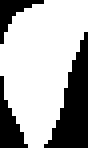
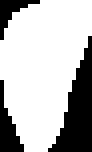
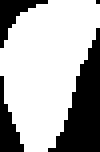
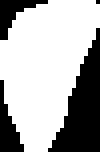
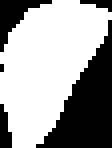
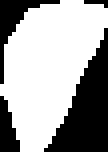

In [41]:
imshow.(tg[1][!,:mask])

,,,,,

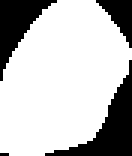
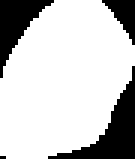
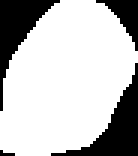
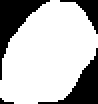
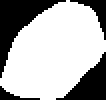
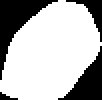

In [42]:
imshow.(tg[2][!,:mask])

Looks good! We can also check the change in location over time. Both (by design) follow approximately the same path.

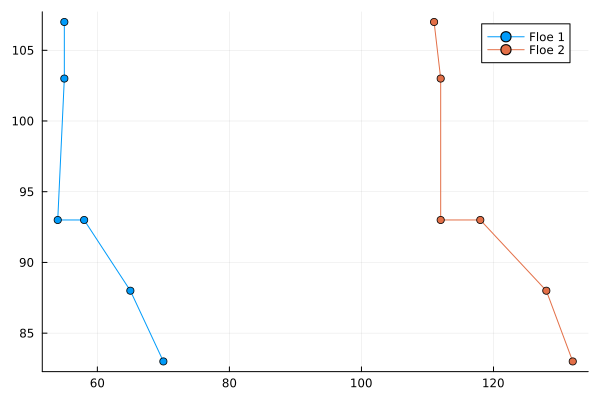

In [43]:
plot(tg[1][!, :col_centroid], tg[1][!, :row_centroid], m=:circle, markersize=4, label="Floe 1")
plot!(tg[2][!, :col_centroid], tg[1][!, :row_centroid], m=:circle, markersize=4, label="Floe 2")

Both floes were manually rotated the same amount as each other, with slightly different rotations each day. This plot shows the progression over time and shows that the orientation was retrieved successfully.

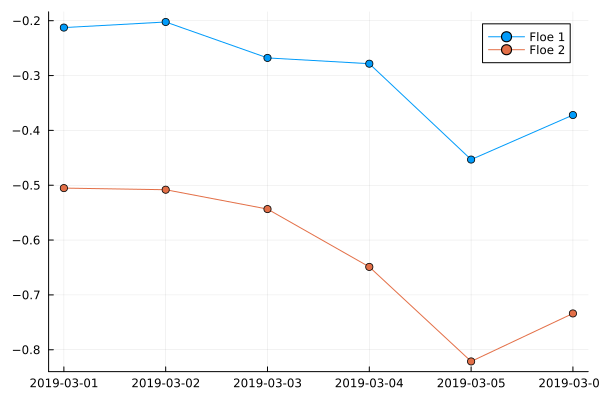

In [44]:
plot(tg[1][!, :passtime], tg[1][!, :orientation], m=:circle, markersize=4, label="Floe 1")
plot!(tg[2][!, :passtime], tg[2][!, :orientation], m=:circle, markersize=4, label="Floe 2")

The results can be saved via the CSV library. We recommend providing a list of the columns desired: saving floe masks and ψ-s curves can result in very large files.

In [59]:
data_columns = [n for n in names(tracked) if n ∉ ["mask", "psi"]];
CSV.write("example_tracked_floes.csv", tracked[!, data_columns]);